# 4. Machine Learning Pipeline – Mortgage Credit Default Risk: Defining Business Rules

Finally, the final decision system based on the predictions of the model must be adequately balanced to identify customers who cannot repay the credit without the system being too strict and incorrectly rejecting those who can pay, affecting the customer experience. Therefore, to decide whether or not to deny a loan, we can use a customer's credit default score assigned by the model and define several thresholds to act based on where that score is.

To increase the default identification rate and ensure a smooth experience for most customers, we defined the following business rules:

- Extreme risk: This rule seeks to correctly identify customers who cannot pay the credit with a very low rate of false positives. Requests identified by this rule may be automatically rejected. Therefore, a false positive rate of less than 5% will be allowed. This rate corresponds to requests whose score is between 0.77 and 1.0.

- High risk: This rule seeks to identify more customers who cannot pay, assuming a higher rate of false positives. The false positive rate tolerance level for this rule equals 20%, and this rate corresponds to requests whose score is between 0.57 and 0.77. But as the number of mislabeled good customers identified by the model increases, customers who fall into this segment must manually go through a more extensive review before being denied.

- Low risk: Applications with a score lower than 0.57 can be automatically approved.


Based on the set of tests, the number of clients that the model identifies as a potential risk of non-reimbursement is evaluated, that is, those whose score is greater than 0.57. The following results are obtained:
Accuracy: 79.12%
Recovery rate: 58.19%
Percentage Amount of credit risk detected: 54.76%

### Imports 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
import shap
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, accuracy_score

from config import FEATURES

/Users/marialanza/opt/miniconda3/envs/my_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Prepare Data

In [2]:
ROOTH_PATH = os.getcwd()
PROCESSED_DATA_PATH = os.path.join(ROOTH_PATH, "data/processed")
model_prediction_on_holdout = test_info = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'test_info.csv')).drop(columns='Unnamed: 0')

TARGET = 'TARGET'
X_test, Y_test = test_info[FEATURES], test_info[TARGET]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61503 entries, 0 to 61502
Data columns (total 70 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   EXT_SOURCE_3                    49251 non-null  float64
 1   EXT_SOURCE_2                    61393 non-null  float64
 2   EXT_SOURCE_1                    26755 non-null  float64
 3   AMT_PAYMENT_min                 58320 non-null  float64
 4   CODE_GENDER                     61503 non-null  object 
 5   AMT_PAYMENT_sum                 58323 non-null  float64
 6   AMT_GOODS_PRICE                 61450 non-null  float64
 7   NAME_EDUCATION_TYPE             61503 non-null  object 
 8   AMT_ANNUITY                     61500 non-null  float64
 9   ORGANIZATION_TYPE               61503 non-null  object 
 10  AMT_CREDIT                      61503 non-null  float64
 11  OWN_CAR_AGE                     21075 non-null  float64
 12  DAYS_EMPLOYED                   

In [3]:
with open('lgbm_credit_risk_pipeline.pickle', 'rb') as handle:
    lgbm_credit_risk_pipeline = pickle.load(handle)

Y_test_scores = lgbm_credit_risk_pipeline.predict_proba(X_test[FEATURES])[:, 1]    

In [4]:
df_scores = X_test[["AMT_CREDIT"]]
df_scores['prediction'] = Y_test_scores
df_scores['Success'] = Y_test


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


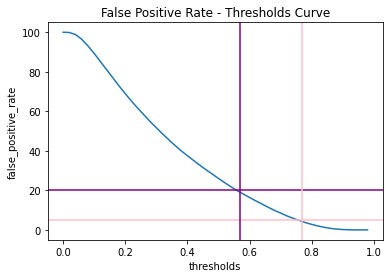

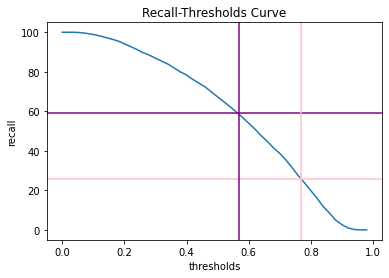

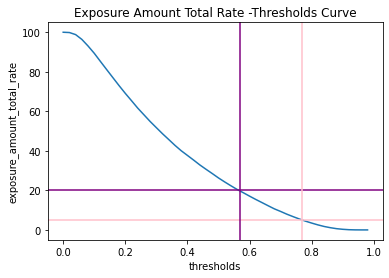

In [5]:
count_non_success = df_scores['Success'][df_scores['Success']==0].count()
count_success = df_scores['Success'][df_scores['Success']==1].count()
exposure_amount_total = df_scores["AMT_CREDIT"].sum()

threshold_v = []
recall_v = []
fpr_v = []
true_positives_v = []
exposure_amount_v = []
threshold_metrics = pd.DataFrame()


for i in range(0, 50, 1):
    threshold = i/50
    df_scores["clasification"] = np.where(df_scores["prediction"]>threshold, 1, 0)
    recall = df_scores["clasification"][df_scores["clasification"]==1][df_scores['Success']==1].sum()/df_scores['Success'].sum()*100
    true_positives = df_scores["clasification"][df_scores["clasification"]==1][df_scores['Success']==1].sum()
    false_positive_rate = df_scores["clasification"][df_scores["clasification"]==1][df_scores['Success']==0].count()/count_non_success*100
    exposure_amount = df_scores["AMT_CREDIT"][df_scores["clasification"]==1].sum()*100
    
    threshold_v.append(threshold)
    recall_v.append(recall)
    fpr_v.append(false_positive_rate)
    true_positives_v.append(true_positives)
    exposure_amount_v.append(exposure_amount)
    
threshold_metrics["thresholds"] = threshold_v
threshold_metrics["recall"] = recall_v
threshold_metrics["false_positive_rate"] = fpr_v
threshold_metrics["true_positives"] = true_positives_v
threshold_metrics["true_positives_rate"] = true_positives_v/count_success*100
threshold_metrics["exposure_amount"] = exposure_amount_v
threshold_metrics["exposure_amount_total_rate"] = exposure_amount_v/exposure_amount_total

extremely_high_treament = 0.77
high_treament = 0.57
plt_x = sns.lineplot(data=threshold_metrics, x="thresholds", y="false_positive_rate")
plt_x.set_title("False Positive Rate - Thresholds Curve")
plt_x.axhline(20, 0, 1, c="purple", label="n_features")
plt_x.axhline(5, 0, 1, c="pink", label="n_features")
plt_x.axvline(high_treament, 0, 1, c="purple", label="n_features")
plt_x.axvline(extremely_high_treament, 0, 1, c="pink", label="n_features")
plt.show()

plt_x = sns.lineplot(data=threshold_metrics, x="thresholds", y="recall")
plt_x.set_title("Recall-Thresholds Curve")
plt_x.axhline(59, 0, 1, c="purple", label="n_features")
plt_x.axhline(26, 0, 1, c="pink", label="n_features")
plt_x.axvline(high_treament, 0, 1, c="purple", label="n_features")
plt_x.axvline(extremely_high_treament, 0, 1, c="pink", label="n_features")
plt.show()

plt_x = sns.lineplot(data=threshold_metrics.astype({}), x="thresholds", y="exposure_amount_total_rate")
plt_x.set_title("Exposure Amount Total Rate -Thresholds Curve")
plt_x.axhline(20, 0, 1, c="purple", label="n_features")
plt_x.axhline(5, 0, 1, c="pink", label="n_features")
plt_x.axvline(high_treament, 0, 1, c="purple", label="n_features")
plt_x.axvline(extremely_high_treament, 0, 1, c="pink", label="n_features")
plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


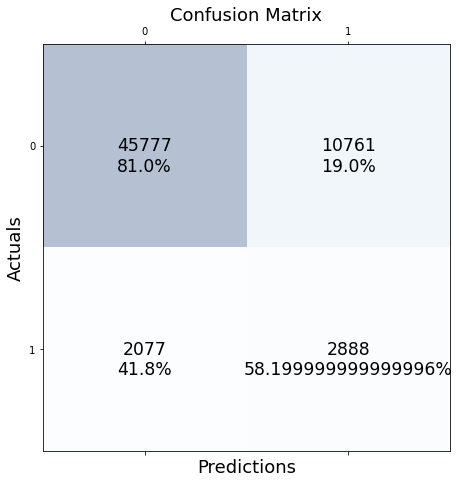

Accuracy: 79.12622148513081
Amount credit risk: 2784057250.5
Amount credit risk detect: 1524797221.5
Porcentage Amount credit risk detect: 54.76888886628159



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
high_treament = 0.57
df_scores['Y_test_predictions'] = np.where(df_scores['prediction']>=high_treament, 1, 0)

conf_matrix = confusion_matrix(y_true=Y_test,y_pred=df_scores['Y_test_predictions'], sample_weight=None, normalize=None)
conf_matrix_norm = confusion_matrix(y_true=Y_test,y_pred=df_scores['Y_test_predictions'], sample_weight=None, normalize='true')
conf_matrix_norm = conf_matrix_norm.round(3)*100

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
        ax.text(x=j, y=i+0.1,s=f'{conf_matrix_norm[i, j]}%', va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print("Accuracy: {}".format(accuracy_score(y_true=Y_test,y_pred=df_scores['Y_test_predictions'])*100))

df_scores['amount_risk_det'] = df_scores[df_scores['Success']==1]['Y_test_predictions']*df_scores['AMT_CREDIT']
df_scores['amount_risk'] = df_scores[df_scores['Success']==1]['Success']*df_scores['AMT_CREDIT']

print('Amount credit risk: {}'.format(df_scores['amount_risk'].sum()))
print('Amount credit risk detect: {}'.format(df_scores['amount_risk_det'].sum()))
print('Porcentage Amount credit risk detect: {}'.format(df_scores['amount_risk_det'].sum()/df_scores['amount_risk'].sum()*100))